In [7]:
#!pip install dgl
# import dgl

In [5]:
#!pip install torch

    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\RENHUA~1\AppData\Local\Temp\pip-install-32is7hgl\torch\setup.py", line 11, in <module>
        raise RuntimeError(README)
    RuntimeError: PyTorch does not currently provide packages for PyPI (see status at https://github.com/pytorch/pytorch/issues/566).
    
    Please follow the instructions at http://pytorch.org/ to install with miniconda instead.
    
    
    ----------------------------------------


Command "python setup.py egg_info" failed with error code 1 in C:\Users\RENHUA~1\AppData\Local\Temp\pip-install-32is7hgl\torch\


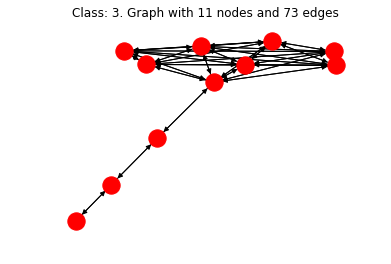

In [13]:
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

# Create training and test sets.
trainset = MiniGCDataset(50, 10, 20)
testset = MiniGCDataset(10, 10, 20)

# Check out a few data points

graph, label = trainset[20]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}.'.format(label)+' Graph with %d nodes and %d edges'%(graph.number_of_nodes(), graph.number_of_edges() ))
plt.show()


In [11]:
!pip install gnnModules

  Could not find a version that satisfies the requirement gnnModules (from versions: )
No matching distribution found for gnnModules


In [14]:
from gnnModules import *
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return (self.classify(hg)).reshape(1,-1)

ModuleNotFoundError: No module named 'gnnModules'

In [ ]:
import torch.optim as optim
import numpy as np

# Create model
model = Classifier(1, 256, trainset.num_classes)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train() # train the model

epoch_losses = []
for epoch in range(500):
    epoch_loss = 0
    sIdx = 0
    for (bg,label) in trainset:
        prediction = model(bg)
        label = torch.tensor([label])
        loss = loss_func(prediction,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        sIdx += 1
    epoch_loss /= (sIdx + 1)
    if np.mod(epoch,10) == 0:
        print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [ ]:
model.eval() # Evaluate the model

# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_Y = torch.tensor(test_Y).float().view(-1, 1)
pred = torch.zeros((len(testset),8))
sIdx = 0
for (bg,label) in testset:
        label = torch.tensor([label])
        pred[sIdx,:] = torch.softmax(model(bg), 1)
        sIdx +=1
        
yPred = torch.max(pred, 1)[1].view(-1, 1).float()
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == yPred).sum().item() / len(test_Y) * 100))